In [16]:
# FUNCTION AND MODULES
import networkx as nx
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Load a weighted network from a gzipped tab-separated file into a NetworkX graph.
## The file should contain three columns: node1, node2, and weight.
def load_network(file_path):
    
    G = nx.Graph()
    with gzip.open(file_path, 'rt') as file:  # 'rt' mode for reading text
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                node1, node2, w = parts
                if node1 != 'protein1' and node2 != 'protein2':
                    G.add_edge(node1, node2)
            else:
                continue  # skip lines that do not match the expected format

    return G

## Load the aliases tsv as dataframe and extract a list of the knwon complexes, 
## as well as a list with all the proteins taking part in comlexes and
## a dataframe with some columns of the table 
def get_list_known_complexes(path_known_complexes):
    # Load known protein complexes from CSV file
    complexes_df = pd.read_csv(path_known_complexes, sep='\t')
    complexes_df = complexes_df[['#Complex ac',  'Recommended name', 'Expanded participant list']]
    complexes_df['Expanded participant list'] = [components.split('|') for components in complexes_df['Expanded participant list']]
    # Extract identifiers from components
    complexes_df['Components'] = complexes_df['Expanded participant list'].apply(lambda x: [component.split('(')[0] for component in x if not component.startswith('CHEBI')])
    complexes_df['N_of_Components'] = [len(components) for components in complexes_df['Components']]
                                       
    list_of_complexes=[row['Components'] for i, row in complexes_df.iterrows() if len(row['Components'])>1]

    for i, complex in enumerate(list_of_complexes):
        for j, protein in enumerate(complex):
            if '-PRO_' in protein:
                list_of_complexes[i][j]=protein.split('-')[0]

    total_ids=[]
    for complex in list_of_complexes:
        total_ids.extend(complex)
    list_total_protein_ids_in_complexes=list(set(total_ids))
    print(len(list_of_complexes))

    complexes_df = complexes_df[['#Complex ac', 'Recommended name', 'Components']]
    return list_of_complexes, list_total_protein_ids_in_complexes, complexes_df

## Using the mapping to map the nodes in the cluster in protein ids
def maps_clusters_to_Uniprot_AC(mapping, clusters):
    clusters = [[mapping[net_code] for net_code in cluster] for cluster in clusters]
    return clusters

## Calculate Jaccard Similiarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))**0.5
    return intersection / union


## 
def get_list_clusters(id_mapper, path_clustering):
    # Load clusters from JSON file
    with open(path_clustering, 'r') as f:
        found_clusters = json.load(f)
    found_clusters_Uni_AC=maps_clusters_to_Uniprot_AC(id_mapper, found_clusters)
    return found_clusters_Uni_AC

## Uses the aliases file to create the mapping from nodes to UniProt_AC ids
def get_mapping(path_to_alias, list_total_protein_ids_in_complexes):
    alias = pd.read_csv(path_to_alias, delimiter='\t')

    id_mapper={}
    mapper_id={}

    for i, row in alias.iterrows():
        # print(row)
        # print(row['source'])
        if row['source'] == 'RefSeq_xref_UniProtKB_Swiss_Prot' or row['source'] == 'UniProt_AC':
            if row['alias'] in list_total_protein_ids_in_complexes:
                id_mapper[row['#string_protein_id']]=row['alias']
                mapper_id[row['alias']]=row['#string_protein_id']

    for i, row in alias.iterrows():
        if row['#string_protein_id'] not in id_mapper.keys():
            if row['source'] == 'RefSeq_xref_UniProtKB_Swiss_Prot':
                    id_mapper[row['#string_protein_id']]=row['alias']
                    mapper_id[row['alias']]=row['#string_protein_id']

    for i, row in alias.iterrows():
        if row['#string_protein_id'] not in id_mapper.keys():
            if row['source'] == 'UniProt_AC':
                    id_mapper[row['#string_protein_id']]=row['alias']
                    mapper_id[row['alias']]=row['#string_protein_id']
                    
    return id_mapper



# FUNCTIONS FOR METRICS CALCULATION

## Calculate the Modularity for a given partiotion and a Graph G
def calculate_modularity_(G, path_clustering):
    """
    Calculate the modularity of a given clustering on graph G from scratch.
    
    Parameters:
        G (networkx.Graph): The graph over which modularity is to be calculated.
        clusters (list of lists): Each sublist contains the nodes in that cluster.
    
    Returns:
        float: The modularity value of the clustering.
    """
    
    # Load clusters from JSON file
    with open(path_clustering, 'r') as f:
        found_clusters = json.load(f)
        
        
    m = G.size()  # Total weight of all edges in the graph
    A = nx.to_numpy_array(G)  # Adjacency matrix as a NumPy array
    nodes = list(G.nodes())
    k = np.array([G.degree(n) for n in nodes])  # Degree array for each node
    
    modularity = 0.0

    # Create a node to cluster mapping for quick lookup
    node_cluster = {}
    for idx, cluster in enumerate(found_clusters):
        for node in cluster:
            node_cluster[node] = idx

    # Calculate the modularity
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if node_cluster.get(nodes[i]) == node_cluster.get(nodes[j]):
                expected_weight = (k[i] * k[j]) / (2 * m)
                actual_weight = A[i, j]
                modularity += (actual_weight - expected_weight)

    modularity = modularity / (2 * m)  # Normalize modularity by 2m
    return modularity

## Get a dictionary in which is saved the best matching cluster for each protein complex
## iff its coverage is > 0.75
def get_best_match_complexes(clusters, complexes):
    # Confronta ogni cluster con i complessi noti
    results = {}
    for i, complex_set in enumerate(complexes):
        complex_set = set(complex_set)
        max_coverage = 0
        max_similarity = 0
        best_match = None
        for j, cluster in enumerate(clusters):
            cluster_set = set(cluster)
            coverage = len(cluster_set.intersection(complex_set)) / len(complex_set)
            similarity = jaccard_similarity(complex_set, cluster_set)
            if coverage > max_coverage:
                max_coverage = coverage
                max_similarity = similarity
                best_match = j
            elif  coverage == max_coverage:
                if similarity > max_similarity:
                    max_coverage = coverage
                    max_similarity = similarity
                    best_match = j
        if max_coverage>0.85:
            results[i]=({
                'Match': best_match,
                'Similarity': max_similarity,
                'Coverage': max_coverage,
            })

    return results

## Calculate precision, recall and f measure for a clustering
def precision_recall_fmeasure(best_complexes_match, found_clusters, actual_complexes):

    true_positives_clusters = len(best_complexes_match)
    total_clusters = len(found_clusters)
    total_complexes = len(actual_complexes)
    
    
    precision = true_positives_clusters / total_clusters
    recall = true_positives_clusters / total_complexes
    f_measure = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f_measure

## Create the dataframe row for a clustering resolution
def evaluate_clusters(found_clusters, actual_complexes):
    
    # Find matching complexes
    best_complexes_match = get_best_match_complexes(found_clusters, actual_complexes)
    precision, recall, f_measure = precision_recall_fmeasure(best_complexes_match, found_clusters, actual_complexes)
        
    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        "Precision": [precision],
        "Recall": [recall],
        "F_measure": [f_measure],
    })
    
    return results_df


#### Results evaluation

In [17]:
# Setting the path to the files

path_known_complexes='./data/83333.tsv'
file_path_alias='./data/511145.protein.aliases.v12.0.txt.gz'

In [18]:
# Loading the data of experimentally determined Complexes
actual_complexes, list_total_protein_ids_in_complexes, complexes_df = get_list_known_complexes(path_known_complexes)
complexes_df

288


,#Complex ac,Recommended name,Components
0,CPX-28,p-aminobenzoyl-glutamate hydrolase complex,"[P76052, P77357]"
1,CPX-93,MutS DNA mismatch repair complex,[P23909]
2,CPX-180,HipBA toxin-antitoxin complex,"[P23873, P23874]"
3,CPX-243,Respiratory chain complex I,"[P0AFC3, P0AFC7, P0AFD1, P0AFD4, P0AFD6, P0AFE..."
4,CPX-268,Cytochrome bd-I ubiquinol oxidase complex,"[P0ABJ9, P0ABK2, P56100]"
...,...,...,...
319,CPX-3176,Endopeptidase ClpXP complex,"[P0A6G7, P0A6H1]"
320,CPX-3178,Endopeptidase ClpP complex,[P0A6G7]
321,CPX-3190,"Taurine dioxygenase complex, dimeric",[P37610]
322,CPX-3206,Acetyl-CoA carboxylase complex,"[P0A9Q5, P0ABD5, P0ABD8, P24182]"


In [19]:
# Creating a mapper between ids. The file 83333.tsv file containing information about known protein complexes uses a 
# set of identifier to refers to proteins e.x. P76052 and P77357 commonly used in order to avoid ambiguity. The network insted 
# uses a specific protein identifiers used by the STRING database. They also provide, in the file 511145.protein.aliases.v12.0.txt.gz, 
# for each node all the different aliases it can have, in order to be able to retrive each node to which proteins referes 

# Creation of a mapper to map nodes to their id in order to compare it to the knwon complexes
id_mapper = get_mapping(file_path_alias, list_total_protein_ids_in_complexes)

In [20]:
# Load the network (needed to calculate modularity)
G=load_network('./data/511145.protein.physical.links.v12.0.txt.gz')

In [21]:
# OH-PIN - Final metrics
resolutions =  [0.05, 0.1, 0.2, 0.4, 1]
df_metrics = pd.DataFrame()

for lamdba in resolutions:
    path_clustering=f'./data/results/OH_PIN/511145_new_OHPIN_clusters_{lamdba}.json'
    
    # Loading the cluster
    found_clusters = get_list_clusters(id_mapper, path_clustering)
    
    # Calulating the metrics
    metrics = evaluate_clusters(found_clusters, actual_complexes)
    metrics['Resolution'] = lamdba
    metrics['NumClusters'] = len(found_clusters)
    metrics['Algorithm'] = 'OH-PIN'
    metrics['Modularity'] = calculate_modularity_(G, path_clustering)
    
    # Append to the df
    df_metrics = pd.concat([df_metrics, metrics], ignore_index=True)

df_metrics_OHPIN = df_metrics[['Algorithm', 'NumClusters', 'Resolution', 'Precision', 'Recall', 'F_measure', 'Modularity']]
display(df_metrics_OHPIN)

,Algorithm,NumClusters,Resolution,Precision,Recall,F_measure,Modularity
0,OH-PIN,1762,0.05,0.157775,0.965278,0.271220,0.273625
1,OH-PIN,1062,0.10,0.261770,0.965278,0.411852,0.327951
2,OH-PIN,573,0.20,0.486911,0.968750,0.648084,0.425553
3,OH-PIN,352,0.40,0.792614,0.968750,0.871875,0.446149
4,OH-PIN,250,1.00,1.116000,0.968750,1.037175,0.405366


In [22]:
# Louvain - Final metrics
resolutions = [5, 11.5, 40, 200, 1000]
resolutions.reverse()   
df_metrics = pd.DataFrame()

for resolution in resolutions:
    path_clustering=f'./data/results/Louvian/new_louvain_clusters_{resolution}.json'
    
    # Loading the cluster
    found_clusters = get_list_clusters(id_mapper, path_clustering)
    
    # Calulating the metrics
    metrics = evaluate_clusters(found_clusters, actual_complexes)
    metrics['Resolution'] = resolution
    metrics['NumClusters'] = len(found_clusters)
    metrics['Algorithm'] = 'Louvain'
    metrics['Modularity'] = calculate_modularity_(G, path_clustering)
    
    # Append to the df
    df_metrics = pd.concat([df_metrics, metrics], ignore_index=True)
    
df_metrics_Louvain = df_metrics[['Algorithm', 'NumClusters', 'Resolution', 'Precision', 'Recall', 'F_measure','Modularity']]
df_metrics_Louvain


,Algorithm,NumClusters,Resolution,Precision,Recall,F_measure,Modularity
0,Louvain,1733,1000.0,0.024235,0.145833,0.041564,0.036069
1,Louvain,1028,200.0,0.090467,0.322917,0.141337,0.075484
2,Louvain,559,40.0,0.289803,0.562500,0.382527,0.147305
3,Louvain,354,11.5,0.502825,0.618056,0.554517,0.203481
4,Louvain,254,5.0,0.708661,0.625000,0.664207,0.260966


In [23]:
# Girvan-Newman - Other metrics
resolutions =  [1762, 1062, 573, 352, 250]
results = []
df_metrics = pd.DataFrame()

for resolution in resolutions:
    path_clustering=f'./data/results/Girvan_Newman/clusters_Girvan-Newman_{resolution}.json'
    
    # Loading the cluster
    found_clusters = get_list_clusters(id_mapper, path_clustering)
    
    # Calulating the metrics
    metrics = evaluate_clusters(found_clusters, actual_complexes)
    metrics['Resolution'] = '-'
    metrics['NumClusters'] = len(found_clusters)
    metrics['Algorithm'] = 'Girvan-Newman'
    metrics['Modularity'] = calculate_modularity_(G, path_clustering)
    
    # Append to the df
    df_metrics = pd.concat([df_metrics, metrics], ignore_index=True)
    
df_metrics_GirvanNewman = df_metrics[['Algorithm', 'NumClusters', 'Resolution', 'Precision', 'Recall', 'F_measure', 'Modularity']]
df_metrics_GirvanNewman

,Algorithm,NumClusters,Resolution,Precision,Recall,F_measure,Modularity
0,Girvan-Newman,1763,-,0.095859,0.586806,0.164798,0.400447
1,Girvan-Newman,1077,-,0.173630,0.649306,0.273993,0.529007
2,Girvan-Newman,577,-,0.383016,0.767361,0.510983,0.572890
3,Girvan-Newman,373,-,0.635389,0.822917,0.717095,0.543142
4,Girvan-Newman,251,-,0.948207,0.826389,0.883117,0.544799


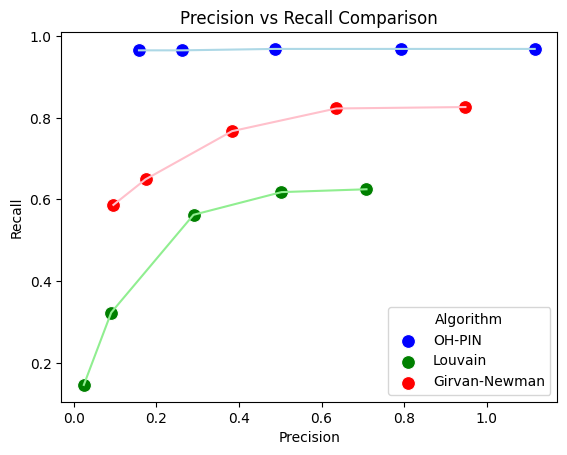

In [24]:
# Plot Precision vs Recall

# Scatter plot with labels for legend
sns.scatterplot(data=df_metrics_OHPIN, x='Precision', y='Recall', s=100, color="blue", label="OH-PIN")
sns.scatterplot(data=df_metrics_Louvain, x='Precision', y='Recall', s=100, color="green", label="Louvain")
sns.scatterplot(data=df_metrics_GirvanNewman, x='Precision', y='Recall', s=100, color="red", label="Girvan-Newman")

# Draw lines with labels
plt.plot(df_metrics_OHPIN['Precision'], df_metrics_OHPIN['Recall'], color='lightblue')
plt.plot(df_metrics_Louvain['Precision'], df_metrics_Louvain['Recall'], color='lightgreen')
plt.plot(df_metrics_GirvanNewman['Precision'], df_metrics_GirvanNewman['Recall'], color='pink')

# Adding the legend
plt.legend(title="Algorithm")

# Optional: Add titles and labels
plt.title('Precision vs Recall Comparison')
plt.xlabel('Precision')
plt.ylabel('Recall')

# Show plot
plt.show()

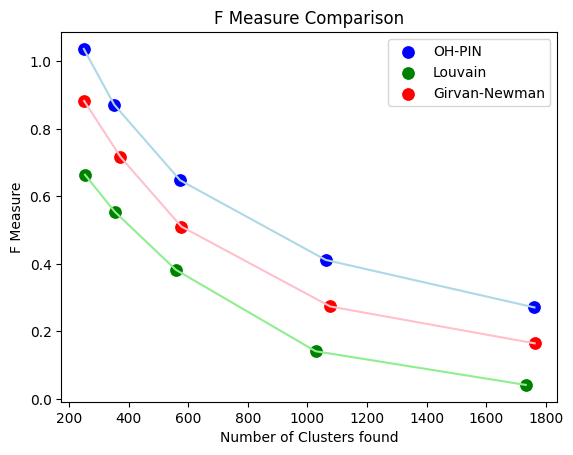

In [25]:
# Plot F Measure

# Scatter plot
sns.scatterplot(data=df_metrics_OHPIN, x='NumClusters', y='F_measure', s=100, color="blue", label="OH-PIN")
sns.scatterplot(data=df_metrics_Louvain, x='NumClusters', y='F_measure', s=100, color="green", label="Louvain")
sns.scatterplot(data=df_metrics_GirvanNewman, x='NumClusters', y='F_measure', s=100, color="red", label="Girvan-Newman")

# Draw lines
plt.plot(df_metrics_OHPIN['NumClusters'], df_metrics_OHPIN['F_measure'], color='lightblue')
plt.plot(df_metrics_Louvain['NumClusters'], df_metrics_Louvain['F_measure'], color='lightgreen')
plt.plot(df_metrics_GirvanNewman['NumClusters'], df_metrics_GirvanNewman['F_measure'], color='pink')

# Optional: Add titles and labels
plt.title('F Measure Comparison')
plt.xlabel('Number of Clusters found')
plt.ylabel('F Measure')

# Show plot
plt.legend()
plt.show()


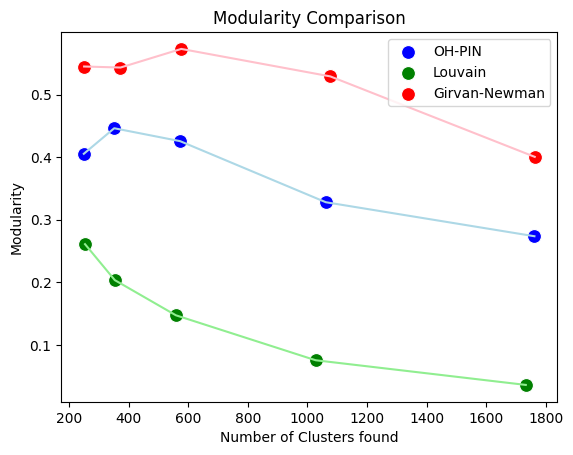

In [26]:
# Plot Modularity 

# Scatter plot
sns.scatterplot(data=df_metrics_OHPIN, x='NumClusters', y='Modularity', s=100, color="blue", label="OH-PIN")
sns.scatterplot(data=df_metrics_Louvain, x='NumClusters', y='Modularity', s=100, color="green", label="Louvain")
sns.scatterplot(data=df_metrics_GirvanNewman, x='NumClusters', y='Modularity', s=100, color="red", label="Girvan-Newman")

# Draw lines
plt.plot(df_metrics_OHPIN['NumClusters'], df_metrics_OHPIN['Modularity'], color='lightblue')
plt.plot(df_metrics_Louvain['NumClusters'], df_metrics_Louvain['Modularity'], color='lightgreen')
plt.plot(df_metrics_GirvanNewman['NumClusters'], df_metrics_GirvanNewman['Modularity'], color='pink')

# Optional: Add titles and labels
plt.title('Modularity Comparison')
plt.xlabel('Number of Clusters found')
plt.ylabel('Modularity')

# Show plot
plt.legend()
plt.show()
